In [1]:
import numpy as np
import pandas as pd
import os
import datetime
import random
from pathlib import Path
from sklearn import metrics
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from keras.applications import imagenet_utils
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from tensorflow.python.client import device_lib 

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5241289093668635452
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 763937860
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15342266312186133126
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Data preprocessing

In [4]:
PATH = "../Datasets/dogs-vs-cats/training/"
IMG_PATH = os.listdir(PATH)
BATCH_SIZE = 32
IMAGE_SIZE = (224,224)

train_dataset = tf.keras.utils.image_dataset_from_directory(os.path.dirname(PATH),
                                                            label_mode='binary',
                                                            shuffle=True,
                                                            seed=111,
                                                            batch_size=BATCH_SIZE, 
                                                            image_size=IMAGE_SIZE,
                                                            validation_split=0.2,
                                                            subset='training')

valid_dataset = tf.keras.utils.image_dataset_from_directory(os.path.dirname(PATH),
                                                            label_mode='binary',
                                                            shuffle=True,
                                                            seed=111,
                                                            batch_size=BATCH_SIZE, 
                                                            image_size=IMAGE_SIZE,
                                                            validation_split=0.2,
                                                            subset='validation')
train_dataset.class_names

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


['cat', 'dog']

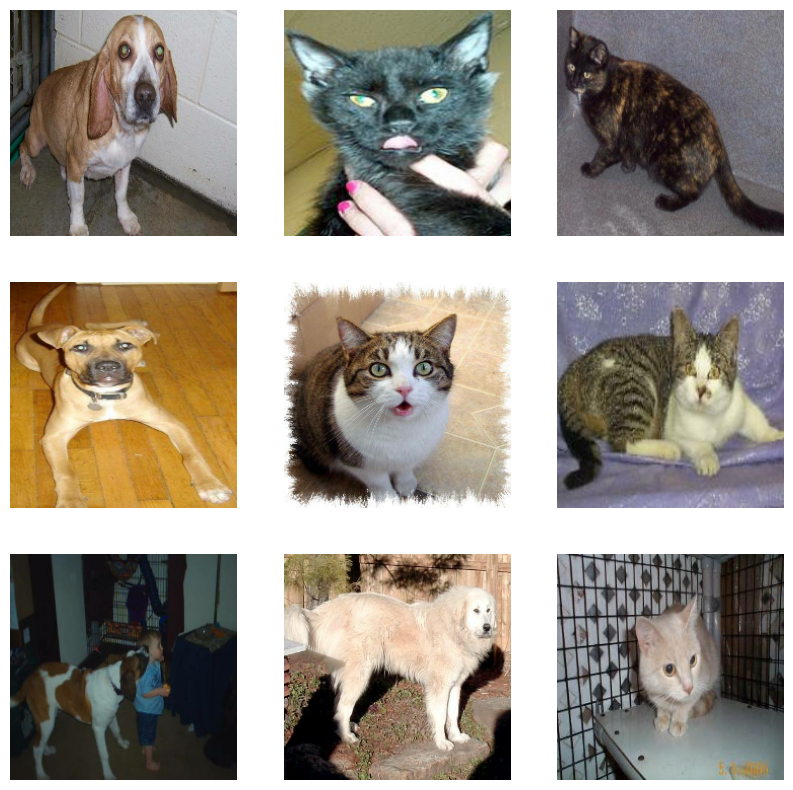

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
# Take 25% of validation dataset to keep as a test set
test_dataset = valid_dataset.take((5000//32)//5)
valid_dataset = valid_dataset.skip((5000//32)//5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 126
Number of test batches: 31


In [7]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(name="Data_Augmentation",layers = [
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.2)
])

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

## Model Creation

In [41]:
# MobileNet
IMAGE_SHAPE = IMAGE_SIZE + (3,)

base_model_mobilenet = MobileNetV2(input_shape = IMAGE_SHAPE,
                                         include_top=False,
                                         classes=2,
                                         weights='imagenet')

base_model_mobilenet.trainable = False
base_model_mobilenet.summary()                                     

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
# Model hyperparameters
epochs = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
opt = Adam(learning_rate=0.0001)
metrics = ['accuracy']

In [12]:
# Create base Mobilenet model
mobilenet_model = Sequential()

mobilenet_model.add(tf.keras.layers.Input(shape=(224,224,3)))
mobilenet_model.add(data_augmentation)
mobilenet_model.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
mobilenet_model.add(base_model_mobilenet)
mobilenet_model.add(tf.keras.layers.GlobalAveragePooling2D())
mobilenet_model.add(tf.keras.layers.Dropout(0.25))
mobilenet_model.add(tf.keras.layers.Dense(1))
mobilenet_model.compile(loss = loss, optimizer = opt, metrics = metrics)

mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Data_Augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                        

In [13]:
# Take inital loss and accuracy of the base MobileNet model
mnet_loss_inital, mnet_accuracy_inital = mobilenet_model.evaluate(test_dataset)

31/31 [==============================] - 8s 79ms/step - loss: 0.6636 - accuracy: 0.5948


In [14]:
# find the length of the training/validation dataset to set steps during training
epoch_steps = len(train_dataset)
val_steps = len(valid_dataset)
print(epoch_steps)
print(val_steps)

625
126


In [15]:
## Setup Tensorboard 
logdir = "logs/hw1/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_mnet = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [17]:
# Train MobileNet using transfer learning 
mnet_history = mobilenet_model.fit(train_dataset,
                                   epochs = epochs,
                                   steps_per_epoch = epoch_steps,
                                   validation_data = valid_dataset,
                                   validation_steps = val_steps,
                                   callbacks=[tensorboard_callback_mnet]
                                   )

Epoch 1/10
625/625 [==============================] - 197s 309ms/step - loss: 0.4053 - accuracy: 0.8054 - val_loss: 0.2174 - val_accuracy: 0.8985
Epoch 2/10
625/625 [==============================] - 157s 250ms/step - loss: 0.2480 - accuracy: 0.8952 - val_loss: 0.1727 - val_accuracy: 0.9154
Epoch 3/10
625/625 [==============================] - 166s 265ms/step - loss: 0.2074 - accuracy: 0.9126 - val_loss: 0.1564 - val_accuracy: 0.9237
Epoch 4/10
625/625 [==============================] - 168s 269ms/step - loss: 0.1927 - accuracy: 0.9192 - val_loss: 0.1443 - val_accuracy: 0.9294
Epoch 5/10
625/625 [==============================] - 195s 312ms/step - loss: 0.1821 - accuracy: 0.9220 - val_loss: 0.1433 - val_accuracy: 0.9299
Epoch 6/10
625/625 [==============================] - 188s 300ms/step - loss: 0.1725 - accuracy: 0.9274 - val_loss: 0.1349 - val_accuracy: 0.9366
Epoch 7/10
625/625 [==============================] - 193s 308ms/step - loss: 0.1667 - accuracy: 0.9303 - val_loss: 0.1365 -

In [18]:
mnet_loss1, mnet_accuracy1 = mobilenet_model.evaluate(test_dataset)

31/31 [==============================] - 3s 80ms/step - loss: 0.1401 - accuracy: 0.9294


## Fine-tuning the Transfer Learning Model

In [42]:
# fine tuning mobile net since it has the lowest accuracy
print("Number of layers in MobileNet Model: ", len(base_model_mobilenet.layers))

Number of layers in MobileNet Model:  154


In [43]:
# Fine-tune starting at 124
fine_tune_start = 124
base_model_mobilenet.trainable = True

for layer in base_model_mobilenet.layers[:fine_tune_start]:
    layer.trainable = False

In [44]:
# Create Fine tuned MobileNet model
opt = Adam(learning_rate=0.00001)

tuned_mobilenet_model = Sequential()
tuned_mobilenet_model.add(tf.keras.layers.Input(shape=(224,224,3)))
tuned_mobilenet_model.add(data_augmentation)
tuned_mobilenet_model.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
tuned_mobilenet_model.add(base_model_mobilenet)
tuned_mobilenet_model.add(tf.keras.layers.GlobalAveragePooling2D())
tuned_mobilenet_model.add(tf.keras.layers.Dropout(0.2))
tuned_mobilenet_model.add(tf.keras.layers.Dense(1))
tuned_mobilenet_model.compile(loss = loss, optimizer = opt, metrics = metrics)

tuned_mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Data_Augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                      

In [45]:
# Fine tune training
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

mnet_history_fine = tuned_mobilenet_model.fit(train_dataset,
                                              epochs = total_epochs,
                                              initial_epoch=mnet_history.epoch[-1],
                                              validation_data=valid_dataset,
                                              callbacks=[tensorboard_callback_mnet])

Epoch 10/20
625/625 [==============================] - 214s 333ms/step - loss: 0.1548 - accuracy: 0.9323 - val_loss: 0.0510 - val_accuracy: 0.9803
Epoch 11/20
625/625 [==============================] - 208s 332ms/step - loss: 0.0530 - accuracy: 0.9804 - val_loss: 0.0380 - val_accuracy: 0.9838
Epoch 12/20
625/625 [==============================] - 205s 327ms/step - loss: 0.0428 - accuracy: 0.9830 - val_loss: 0.0363 - val_accuracy: 0.9843
Epoch 13/20
625/625 [==============================] - 226s 362ms/step - loss: 0.0324 - accuracy: 0.9881 - val_loss: 0.0351 - val_accuracy: 0.9845
Epoch 14/20
625/625 [==============================] - 209s 333ms/step - loss: 0.0251 - accuracy: 0.9908 - val_loss: 0.0352 - val_accuracy: 0.9855
Epoch 15/20
625/625 [==============================] - 242s 387ms/step - loss: 0.0222 - accuracy: 0.9920 - val_loss: 0.0333 - val_accuracy: 0.9858
Epoch 16/20
625/625 [==============================] - 245s 392ms/step - loss: 0.0174 - accuracy: 0.9937 - val_loss: 0

In [48]:
mnet_loss2, mnet_accuracy2 = tuned_mobilenet_model.evaluate(test_dataset)

31/31 [==============================] - 3s 82ms/step - loss: 0.0221 - accuracy: 0.9950


## Results

In [49]:
print("The loss and accuracy of the base MobileNetV2 model before training was {:.4f} and {:.4f}".format(mnet_loss_inital, mnet_accuracy_inital))
print("The loss and accuracy of the transfer learning MobileNetV2 model was {:.4f} and {:.4f}".format(mnet_loss1, mnet_accuracy1))
print("The loss and accuracy of the fine-tuned transfer learning MobileNetV2 model was {:.4f} and {:.4f}".format(mnet_loss2, mnet_accuracy2))

The loss and accuracy of the base MobileNetV2 model before training was 0.6636 and 0.5948
The loss and accuracy of the transfer learning MobileNetV2 model was 0.1401 and 0.9294
The loss and accuracy of the fine-tuned transfer learning MobileNetV2 model was 0.0221 and 0.9950


In [50]:
%tensorboard --logdir logs/hw1/

Reusing TensorBoard on port 6006 (pid 19772), started 1:49:20 ago. (Use '!kill 19772' to kill it.)